In [4]:
# Always reload modules before executing code.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import time

import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn import linear_model

import ransac

RANSAC example. The example problem is based on http://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py.

Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] 82.08533158726632


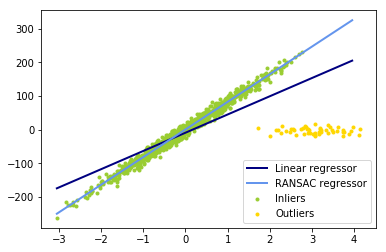

RANSAC ran in 0.04 seconds


In [6]:
n_samples = 1000
n_outliers = 50

X, y, coef = datasets.make_regression(
    n_samples=n_samples, n_features=1, n_informative=1, noise=10,
    coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)
points = np.array(list(zip([x[0] for x in X], y)))

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Fit with ransac
ransac_model = ransac.LeastSquaresModel()
my_ransac = ransac.Ransac(ransac_model, 20, 50, 5000, 100, random_seed=0)
run_time = time.time()
ransac_results = my_ransac.run(points)
run_time = time.time() - run_time

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac_model.predict(line_X, ransac_results.fit)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac_results.fit[0])

lw = 2
plt.scatter(ransac_results.inliers[:, 0], ransac_results.inliers[:, 1],
            color='yellowgreen', marker='.', label='Inliers')
plt.scatter(ransac_results.outliers[:, 0], ransac_results.outliers[:, 1],
            color='gold', marker='.', label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.show()
print('RANSAC ran in %0.2f seconds' % run_time)

X-RANSAC example.

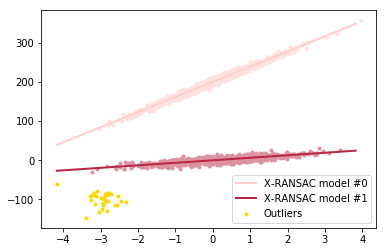

XRANSAC ran in 0.36 seconds


In [7]:
random_state = np.random.RandomState(1)
n_samples = 1000
n_outliers = 30

X, y, coef = datasets.make_regression(
    n_samples=n_samples, n_features=1, n_informative=1, noise=5,
    coef=True, random_state=random_state)
X2, y2, coef2 = datasets.make_regression(
    n_samples=n_samples, n_features=1, n_informative=1, noise=5,
    coef=True, random_state=random_state)

X = np.concatenate((X, X2))
y = np.array([e + 200 for e in y])
y = np.concatenate((y, y2))

X[:n_outliers] = -3 + 0.5 * random_state.normal(size=(n_outliers, 1))
y[:n_outliers] = -100 + 20 * random_state.normal(size=n_outliers)

# Fit with ransac
ransac_model = ransac.LeastSquaresModel()
my_ransac = ransac.XRansac(
    ransac_model, 2, 50, 500, 50,
    random_seed=0, residual_histogram_num_bins=200, min_prominence=5)
run_time = time.time()
ransac_results = my_ransac.run(np.array(list(zip([x[0] for x in X], y))))
run_time = time.time() - run_time

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y_xransac_per_model = []
for result in ransac_results.get_model_results():
    line_y_xransac_per_model.append(ransac_model.predict(line_X, result.fit))

# Display results
outliers = ransac_results.get_global_outliers()
if len(outliers) > 0:
    plt.scatter(
        outliers[:, 0], outliers[:, 1],
        color='gold', marker='.', label='Outliers')
colors = [
    '#ffcecc', '#ba2644', '#4c072c', '#00bcb5', '#b6c399',
    '#ffe1e0', '#dc92a1', '#936a80', '#66d6d2', '#d3dbc1',
    '#0000FF', '#00FF00', '#FF00FF']
for i, result in enumerate(ransac_results.get_model_results()):
    plt.scatter(result.inliers[:, 0], result.inliers[:, 1],
            color=colors[min(len(colors), i + 5)], marker='.')
    plt.plot(line_X, line_y_xransac_per_model[i], color=colors[min(len(colors), i)],
             linewidth=lw, label='X-RANSAC model #%s' % i)
plt.legend(loc='lower right')
plt.show()
print('XRANSAC ran in %0.2f seconds' % run_time)